# K-Nearest Neighbors for Classification

So far we have trained machine learning models to predict quantitative targets. Such models are called _regression models_ (or _regressors_). Now we will train machine learning models to predict categorical targets. In other words, the goal is to "classify" observations as belonging to one category (class) or the other. These models are called _classification models_ (or _classifiers_). As with regression, in classification models the feature variables are usually a mix of categorical and quantitative variables. The difference between regression and classification is in the type of the target variable being predicted - quantitative or categorical.

In 2012, Brittany Wenger, a 17-year old high school student from Florida, won first place in the Google Science Fair. She built [a cloud-based application](http://cloud4cancer.appspot.com/) that predicts whether a patient has breast cancer, based on attributes observed in a biopsy of breast tissue. Her classifier, based on a type of machine learning model called a _neural network_, was 97.4% accurate, with a 99.1% sensitivity to malignancy. What do these numbers mean?

First, we read in the data that Brittany Wenger trained her classifier on. The observational units are samples from biopsies of breat tissue. The target variable **Class** denotes whether the tumor is benign (0) or malignant (1).



In [ ]:
import pandas as pd

df_breast = pd.read_csv("http://dlsun.github.io/pods/data/breast-cancer.csv")
df_breast.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


We focus on just two features for now: **Clump Thickness** and **Uniformity of Cell Size**. Let's plot the training data, using color to represent the class label.

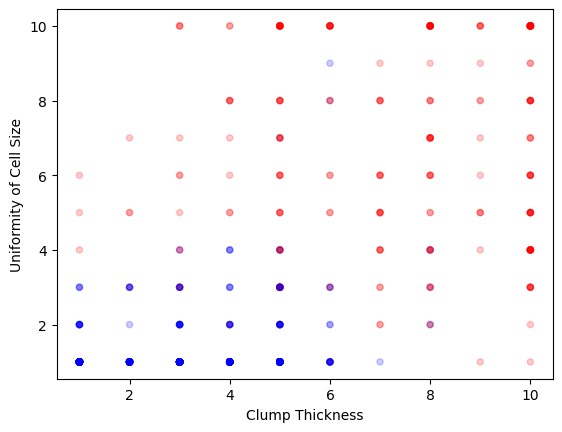

In [ ]:
colors = df_breast["Class"].map({
    0: "blue",
    1: "red"
})

df_breast.plot.scatter(
    x="Clump Thickness", y="Uniformity of Cell Size", c=colors,
    alpha=.2
);

Now, suppose that we have a new sample of breast mass with clump thickness 6 and uniformity of cell size 7, represented by a black circle on the plot below. Is this likely a malignant or a benign tumor?

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/classification.png?raw=1)

It is not hard to guess that this tumor is probably malignant, just by looking at the plot. The reasoning goes like this: most of the breast masses in the training data that were "close" to this one were malignant, so it makes sense to predict that this mass is also malignant. This is the idea behind the $k$-nearest neighbors classifier:

1. Calculate the distance between the new point and each point in the training data, using some distance metric on the features.
2. Determine the $k$ closest points in the training data. Of these $k$ closest points, count up how many of each class label there are.
3. The predicted class of the new point is whichever class was most common among the $k$ closest points.

The only difference between the $k$-nearest neighbors classifier and the $k$-nearest neighbors regressor we have seen previously is the last step. Instead of averaging the labels of the $k$ neighbors to obtain our prediction, we count up the number of occurrences of each category among the labels and take the most common one. It makes sense that we have to do something different because the label is now categorical instead of quantitative. Remember: the analysis changes depending on the variable type!

# Implementing K-Nearest Neighbors from Scratch

We will eventually use a package to fit $k$-nearest neighbors classification, but it is instructive to first do it from scratch.


Let's classify the breast mass above using 10-nearest neighbors. First, we extract the training data and scale the features.

In [ ]:
X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size"]]
y_train = df_breast["Class"]

X_train_sc = (X_train - X_train.mean()) / X_train.std()

Next, we create a `Series` for the new breast mass (with clump thickness 6 and uniformity of cell size 7), being sure to scale it in the same way as the training data.

In [ ]:
x_new = pd.Series()
x_new["Clump Thickness"] = 6
x_new["Uniformity of Cell Size"] = 7

x_new_sc = (x_new - X_train.mean()) / X_train.std()
x_new_sc

,0
Clump Thickness,0.552274
Uniformity of Cell Size,1.255795


Now, we calculate the (Euclidean) distance between this new mass and each mass in the training data, and sort the distances from smallest to largest.

In [ ]:
import numpy as np
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
dists_sorted = dists.sort_values()
dists_sorted

,0
304,0.326249
225,0.326249
3,0.326249
452,0.326249
499,0.326249
...,...
662,2.640793
660,2.640793
658,2.640793
28,2.640793


The first 10 entries of this sorted list will be the 10 nearest neighbors. Let's get their index.

In [ ]:
inds_nearest = dists_sorted.index[:10]
inds_nearest

Index([304, 225, 3, 452, 499, 566, 434, 550, 652, 251], dtype='int64')

Now we can look up these indices in the original data.

In [ ]:
df_breast.loc[inds_nearest]

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
304,709287,6,8,7,8,6,8,8,9,1,1
225,1231387,6,8,7,5,6,8,8,9,2,1
3,1016277,6,8,8,1,3,4,3,7,1,0
452,1299596,6,6,6,5,4,10,7,6,2,1
499,1306282,6,6,7,10,3,10,8,10,2,1
566,878358,5,7,10,6,5,10,7,5,1,1
434,1193544,5,7,9,8,6,10,8,10,1,1
550,1331412,5,7,10,10,5,10,10,10,1,1
652,1350319,5,7,4,1,6,1,7,10,3,1
251,242970,5,7,7,1,5,8,3,4,1,0


As a quick reasonableness check, notice that these observations all have a clump thickness near 6 and a uniformity of cell size near 7. To make a prediction for the new mass, we need to count up how many malignant and benign masses there were among these 10-nearest neighbors.

In [ ]:
df_breast.loc[inds_nearest]["Class"].value_counts()

,count
Class,
1,8
0,2


There were more malignant tumors, by an 8 to 2 margin, so the 10-nearest neighbors model predicts that the breast is malignant.

Classification models often report the predicted _probability_ of each label, instead of just the predicted label. In a $k$-nearest neighbors classification model, the predicted probability of a class is simply the proportion of the $k$ neighbors that are in that class. In the example above, instead of simply predicting that the breast mass is malignant, we could have instead said that it has an estimated $8/10 = 0.8$ probability of being malignant.

# K-Nearest Neighbors Classifier in Scikit-Learn

Now let's implement the same $10$-nearest neighbors model above using Scikit-Learn.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# define a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)

# fit the pipeline (using X_train and y_train defined above)
pipeline.fit(X_train, y_train)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

Compare the code above to what we have seen previously for $k$-nearest neighbors regression. The only difference is that `KNeighborsClassifier` replaces `KNeighborsRegressor`.

Now that we have fit the model we can use it to predict the class  of a new breast mass with clump thickness 6 and uniformity of cell size 7.

In [ ]:
# define the test data (recall that scikit-learn expects a 2D-array)
pipeline.predict([[6, 7]])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1])

The mass is predicted to be of class 1, malignant.

What if we want the predicted probabilities? For classification models, there is an additional method, `.predict_proba()`, that returns the predicted probability of each class.

In [ ]:
pipeline.predict_proba([[6, 7]])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.2, 0.8]])

The first number represents the probability of the first class (0 for benign) and the second number represents the probability of the second class (1 for malignant). Notice that the predicted probabilities add up to 1, as they must.

We can also use the model to make predictions for a series of observations. For example, we can use the model to predict the class for each observation in the training data.

In [ ]:
pipeline.predict(X_train)

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

Or the predicted probabilities in each class for each observation in the training data.

In [ ]:
pipeline.predict_proba(X_train)

array([[1. , 0. ],
       [0.2, 0.8],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

For the training data, we can compare the predicted classes to the actual classes.

In [ ]:
pd.crosstab(y_train, pd.Series(pipeline.predict(X_train), name = "Predicted"))

Predicted,0,1
Class,,
0,426,18
1,14,225


How can we evaluate the effectiveness of a classification model? We'll investigate that in the next notebook, but brainstorm some ideas before proceeding.

# Evaluating Classification Models


How do we measure how good a classification model is? Perhaps the most obvious metric is _accuracy_, which simply measures how often the predicted label matches the actual label. (Remember that the label in a classification model is a _categorical variable_.) Let's train a $10$-nearest neighbors model on the breast cancer data, just so that we have a model to evaluate.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size"]]
y_train = df_breast["Class"]

# define a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)

pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

Now, we calculate the model's predictions on the training data, and compare to the actual labels in the training data.

In [ ]:
y_train_ = pd.Series(pipeline.predict(X_train), name = "Predicted")

pd.crosstab(y_train, y_train_, margins=True)

Predicted,0,1,All
Class,,,
0,426,18,444
1,14,225,239
All,440,243,683


The two-way table above is a called a **confusion matrix**, which can also be computed using scikit-learn.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_)


array([[426,  18],
       [ 14, 225]])

The predictions were correct for 426 + 225 = 651 observations out of 683 total, for an accuracy of 651/683 = 0.953, or 95.3%.

There is also a scikit-learn function that calculates the accuracy.

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_)

0.9531478770131772

The accuracy is 95.3%, which sounds impressive. Is it? Consider the hypothetical example represented by the table below. The accuracy here is also 95%. But would you say this is a great model? Also, given this hypothetical training data, can you think of a simple model that achieves even better than 95% accuracy?

|       | Predicted |    0 |   1 |   All |
|-------|----------:|-----:|----:|------:|
| Class |           |      |     |       |
| 0     |           | 9400 | 300 |  9700 |
| 1     |           |  200 | 100 |   300 |
| All   |           | 9600 | 400 | 10000 |

This model represented by the table above has 95% accuracy ((9400+100)/10000) but does a very poor job at identifying malignant samples:

- out of the 300 malignant samples in the training data, the model only correctly predicted 33% as malignant
- out of the 400 samples predicted to be malignant, only 25% actually were.

Also, in this case, a different model which simply predicts that every sample is benign would have 97% training accuracy, but would never correctly predicted malignant samples.

Going back to the real data and model, the accuracy of 95.3% would be less impressive if 95.3% of all samples in the data were benign, since the same accuracy could be achieved by a simple model that predicts that every sample is benign.

The problem with a model that predicts that every sample is benign is that, although the model might be accurate overall, it is very inaccurate for malignant samples. We want a model that is not just accurate overall, but accurate for both benign and malignant samples. There is some ambiguity in how to define "accuracy for malignant samples". As a result, there are two metrics: _precision_ and _recall_.

## Precision and Recall

Suppose we want to calculate the "accuracy" of our model for class $c$. There are two ways to interpret "accuracy for class $c$". Do we want to know the accuracy among the observations our model _predicted to be_ in class $c$ or the accuracy among the observations that _actually were_ in class $c$? The two options lead to two different notions of "accuracy" for class $c$: precision and recall.

The **precision** (a.k.a. positive predictive value) of a model for class $c$ is the proportion of observations predicted to be in class $c$ that actually were in class $c$.

$$ \textrm{precision for class } c = \frac{\text{number of observations in class $c$ that were predicted to be in $c$}}{\text{number of observations predicted to be in class $c$}}. $$

The **recall** (a.k.a. sensitivity) of a model for class $c$ is the proportion of observations actually in class $c$ that were predicted to be in class $c$.

$$ \textrm{recall for class } c = \frac{\text{number of observations in class $c$ that were predicted to be in $c$}}{\text{number of observations in class $c$}}. $$

Another way to think about precision and recall is in terms of true positives (TP) and false positives (FP). A "positive" is an observation that the model identified as belonging to class $c$ (i.e., $\hat y = c$). A true positive is one that actually was in class $c$ (i.e., $\hat y = c$ and $y = c$), while a false positive is one that was not (i.e., $\hat y = c$ and $y \neq c$). True negatives (TN) and false negatives (FN) are defined analogously.

In the language of positives and negatives, the precision is the proportion of positives that are true positives:
$$ \textrm{precision for class } c = \frac{TP}{TP + FP}, $$
The recall is the proportion of observations in class $c$ that are positives (as opposed to negatives):
$$ \textrm{recall for class } c = \frac{TP}{TP + FN}. $$

The figure below may help you to remember which numbers go in the numerator and denominator. The precision is the proportion of the circle that TP makes up, while the recall is the proportion of the red rectangle that TP makes up.

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/precision_recall.png?raw=1)

Let's calculate the precision and recall of our $10$-nearest neighbors model for benign masses (**Class** = 0). Be sure to carefully note the difference between `y_train` and `y_train_` in the code below.

In [ ]:
true_positives = ((y_train_ == 0) & (y_train == 0)).sum()

precision = true_positives / (y_train_ == 0).sum()

recall = true_positives / (y_train == 0).sum()

precision, recall

(np.float64(0.9681818181818181), np.float64(0.9594594594594594))

You can also have scikit-learn calculate the precision and recall. These functions work similarly to `accuracy_score` above, except we have to explicitly specify the class for which we want the precision and recall. For example, to calculate the precision and recall for benign (0) masses:

In [ ]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train == 0, y_train_ == 0),
 recall_score(y_train == 0, y_train_ == 0))

(0.9681818181818181, 0.9594594594594594)

It is important to specify the class explicitly when calculating the precision and recall. Each class has a different precision and recall. For example, the precision and recall for malignant masses is lower.

In [ ]:
true_positives_1 = ((y_train_ == 1) & (y_train == 1)).sum()

precision_1 = true_positives_1 / (y_train_ == 1).sum()
recall_1 = true_positives_1 / (y_train == 1).sum()

precision_1, recall_1

(np.float64(0.9259259259259259), np.float64(0.9414225941422594))

In [ ]:
(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.9259259259259259, 0.9414225941422594)

## Precision-Recall Curves

In general, there is a tradeoff between precision and recall. For example, you can improve recall by casting a wider net, predicting more observations to be in class $c$, but this will hurt precision in general. To take an extreme example, a model that predicts that _every_ observation is in class $c$ necessarily has 100% recall, but its precision will likely be poor. To visualize this phenomenon, suppose we expand the positives from the dashed circle to the solid circle, as shown in the figure on the right below. This increases recall (because the circle now covers more of the red rectangle) but decreases precision (because the red rectangle now makes up a smaller fraction of the circle).

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/precision_recall_tradeoff.png?raw=1)


Likewise, we can improve precision by predicting fewer observations to be in class $c$ (i.e., only the ones you are very confident about), but this will hurt recall. This is illustrated in the figure above, at left.

How do we cast a wider (or narrower) net? In many classification models, the predicted label is obtained by first obtaining the predicted probabilities and then choosing the class with the highest probability.

In the case of the breast cancer data set, there are only two classes, so we predict that a breast mass is malignant if the predicted probability of malignancy is $0.5$ or higher. (We predict it is benign otherwise). Instead of using $0.5$ as the threshold, we could cast a wider net for malignancy by lowering the threshold to $0.4$, predicting a breast mass to be malignant as long as the predicted probability is $0.4$ or higher.

In [ ]:
probas_ = pipeline.predict_proba(X_train)
probas_

array([[1. , 0. ],
       [0.2, 0.8],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

In [ ]:
y_train_ = (probas_[:, 1] >= 0.4)

(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.9051383399209486, 0.9581589958158996)

We see that recall for malignancy increases from 94.1% to 95.8% when we cast this wider net, at the expense of precision, which drops from 92.6% to 90.5%.

It is often instructive to calculate the precision and recall for all possible thresholds and then graph the values as a _precision-recall curve_. Scikit-learn provides a function to calculate the precision and recall for different thresholds.

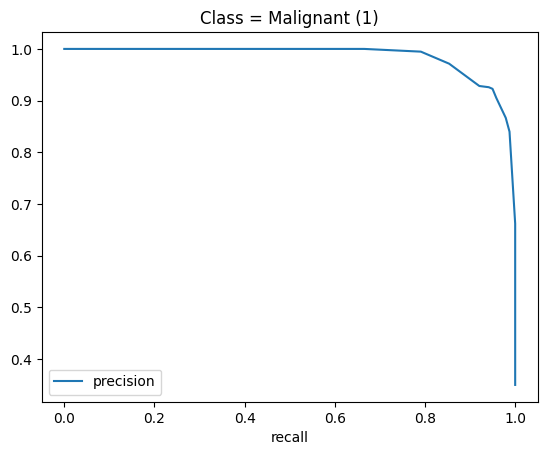

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train == 1, probas_[:, 1]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision", title="Class = Malignant (1)");

This curve makes the tradeoff between precision and recall explicit. As we lower the threshold, the recall for malignant masses increases from 0% to 100%, while the precision decreases from 100% to about 35%.

We can also plot the precision-recall curve for benign (0) masses.

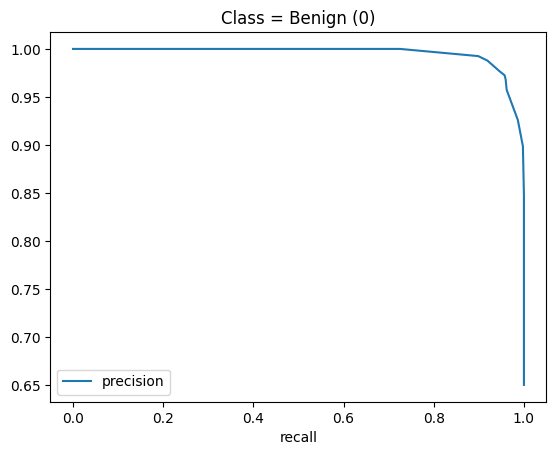

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(
    y_train == 0, probas_[:, 0]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision", title="Class = Benign (0)");

## F1 Score: Combining Precision and Recall

We have replaced accuracy by two numbers: precision and recall. We can combine the precision and recall into a single number, called the **F1 score**.

The F1 score is defined to be the **harmonic mean** of the precision and the recall. That is,

$$ \frac{1}{\text{F1 score}} = \frac{ \frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}, $$

or equivalently,

$$ \text{F1 score} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}. $$

The harmonic mean of two numbers is always between the two numbers, but in general will be closer to the smaller number. For example, if precision is $90\%$ and recall is $10\%$, then the harmonic mean is

$$ \text{F1 score} = \frac{2 \cdot 0.9 \cdot 0.1}{0.9 + 0.1} = 18\%. $$

This is a desirable property of F1 scores because we want to encourage models to have both high precision _and_ high recall. It is not sufficient for one of these to be high if the other is very low. In other words, we do not want a high precision to compensate for a low recall, or vice versa. (This is why we don't just simply take the average of precision and recall.)

The F1 score for benign masses is:

In [ ]:
2 * precision * recall / (precision + recall)

np.float64(0.9638009049773756)

We could have also asked Scikit-Learn calculate this for us. If we know the actual and predicted labels, we can use the `f1_score` function, which works similarly to `precision_score` and `recall_score` from above:

In [ ]:
from sklearn.metrics import f1_score

# changing the predicted values back to what they were before we changed the threshold
y_train_ = pd.Series(pipeline.predict(X_train), name = "Predicted")

f1_score(y_train == 0, y_train_ == 0)

0.9638009049773756

Likewise, we can compute the F1 score for malignant masses.

In [ ]:
2 * precision_1 * recall_1 / (precision_1 + recall_1)

np.float64(0.9336099585062242)

In [ ]:
f1_score(y_train == 1, y_train_ == 1)

0.9336099585062241

Accuracy, precision, recall, and F1 score are measures for evaluating classification models. So far we have focused on computing these measures for the *training* data. But just as with regression, we really want to evaluate models based on their *test* scores. We will see how to so this in the next notebook. But consider what we have already seen for regression; what will be different for classification?

# Estimating Test Metrics for Classification

We have learned several scores (accuracy, precision, recall, F1) for evaluating classification models. We calculated these scores on the training data---that is, the same data that was used to evaluate the model. When studying regression models, we saw that evaluating machine learning models on the training data is problematic because a machine learning model can achieve a good training score by _overfitting_ to the training data. We argued that the goal of a machine learning model should be to achieve a good score on test data. However, true labels are often not available for the test data. Nevertheless, we can use cross-validation on the training data to estimate the test scores. These so-called validation scores can be used to select between models and tune hyperparameters.

The same cross-validation process for regression models can be carried out for classification models. Instead of calculating the *training* accuracy, precision, etc., we estimate the *test* accuracy, precision, etc. using cross-validation. This notebook demonstrates how to carry out this program, but the concepts (and even the code) are essentially identical what we did for regression models.

First, we define a classifier that we want to evaluate, once again using the breast cancer data.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

df_breast = pd.read_csv("http://dlsun.github.io/pods/data/breast-cancer.csv")

X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size"]]
y_train = df_breast["Class"]

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)

pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

To calculate test scores using $k$-fold cross validation, we use the `cross_val_score` function in scikit-learn. For example, to calculate test accuracy, we do the following:

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline, X_train, y_train,
                            cv=10, scoring="accuracy")
cv_scores

array([0.92753623, 0.89855072, 0.94202899, 0.94117647, 0.94117647,
       0.91176471, 0.95588235, 0.98529412, 0.98529412, 0.97058824])

Compare to the code we used to perform cross-validation for regression; the only change is to `scoring`.

We get 10 accuracy scores, one from each of the $k=10$ folds. It is customary to average these accuracy scores to obtain one overall estimate of the test accuracy.

In [ ]:
cv_scores.mean()

np.float64(0.9459292412617222)

This validation accuracy is high, but a little lower than the 95.3% training accuracy that we obtained in the previous lesson. This makes sense because it is always harder for a model to predict on data it has not seen than on data it saw.

However, accuracy is still not a great performance measure, even if it is test accuracy (rather than training accuracy). Instead, we focus on precision, recall, and F1 score.

Remember that each class of the target variable has its own precision, recall, and F1 score. Scikit-Learn can calculate the precision and recall of a class $c$, but the labels need to be converted to a binary label&mdash;that is, $1$ (or `True`) if the observation is in class $c$ and $0$ (or `False`) otherwise. For example, to calculate the precision for malignant tumors (class 1), we define the new label `is_malignant`.

In [ ]:
is_malignant = (y_train == 1)

cv_scores = cross_val_score(pipeline, X_train, is_malignant,
                cv=10, scoring="precision")

cv_scores

array([0.91304348, 0.94736842, 0.91666667, 0.88      , 0.85714286,
       0.95      , 1.        , 0.96      , 1.        , 0.92307692])

Once again, we get 10 precision scores, one from each of the $k=10$ folds, which we can average to get an overall estimate of the test precision.

In [ ]:
precision_1 = cv_scores.mean()
precision_1

np.float64(0.9347298346199949)

To calculate recall or F1 score for malignancy we just need to change the scoring.

In [ ]:
recall_1 = cross_val_score(pipeline, X_train, is_malignant,
                cv=10, scoring="recall").mean()
recall_1

np.float64(0.9123188405797101)

In [ ]:
f1score_1 = cross_val_score(pipeline, X_train, is_malignant,
                cv=10, scoring="f1").mean()

f1score_1

np.float64(0.9202521517972144)

Likewise, the validation precision, recall, and F1 score for benign (class = 0) tumors is

In [ ]:
is_benign = (y_train == 0)

precision_0 = cross_val_score(pipeline, X_train, is_benign,
                              cv=10, scoring="precision").mean()

recall_0 = cross_val_score(pipeline, X_train, is_benign,
                           cv=10, scoring="recall").mean()

f1score_0 = cross_val_score(pipeline, X_train, is_benign,
                            cv=10, scoring="f1").mean()

precision_0, recall_0, f1score_0

(np.float64(0.9744094432699084),
 np.float64(0.945959595959596),
 np.float64(0.9590840279447874))

Remember that each category of the target variables has its own precision, recall, and F1 score. We can average these values over the categories to get a "model" precision, recall, and F1 score using `_macro` scoring.

In [ ]:
precision_macro = cross_val_score(pipeline, X_train, y_train,
                                  cv=10, scoring="precision_macro").mean()

recall_macro = cross_val_score(pipeline, X_train, y_train,
                               cv=10, scoring="recall_macro").mean()

f1score_macro = cross_val_score(pipeline, X_train, y_train,
                                cv=10, scoring="f1_macro").mean()

precision_macro, recall_macro, f1score_macro

(np.float64(0.9452081010187369),
 np.float64(0.938179622310057),
 np.float64(0.9396101884414062))

## Hyperparameter Tuning

Could we do better with a different value of $k$ in our $k$-nearest neighbors model? We can use cross-validation on a grid of $k$ values and pick the one that maximizes some score. Since the F1 score summarizes both precision and recall, we'll use F1 as the score. There are two F1 scores---one for the benign masses and the malignant masses---`_macro` specifies that we take the average.

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    pipeline,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 50)},
    scoring="f1_macro",
    cv=10
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 7}

The grid search identifies $k=7$ as optimal. How does this value compare to other values of $k$?

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,0.011801,0.004405,0.014957,0.006323,7,{'kneighborsclassifier__n_neighbors': 7},0.937273,0.881763,0.968636,0.935606,0.937729,0.918719,0.967150,0.984049,0.984049,0.968372,0.948334,0.030699,1
8,0.013161,0.008976,0.015003,0.008633,9,{'kneighborsclassifier__n_neighbors': 9},0.937273,0.881763,0.952534,0.935606,0.937729,0.918719,0.951231,0.984049,0.983744,0.968372,0.945102,0.029254,2
7,0.015703,0.007234,0.022235,0.011247,8,{'kneighborsclassifier__n_neighbors': 8},0.937273,0.881763,0.936111,0.935606,0.937729,0.918719,0.950183,0.984049,0.983744,0.968372,0.943355,0.029226,3
22,0.008679,0.006209,0.010774,0.004399,23,{'kneighborsclassifier__n_neighbors': 23},0.919336,0.881763,0.936111,0.934300,0.984049,0.883761,0.950183,0.984049,0.984049,0.967803,0.942540,0.036962,4
23,0.010331,0.005964,0.013565,0.006862,24,{'kneighborsclassifier__n_neighbors': 24},0.919336,0.881763,0.919336,0.934300,0.984049,0.883761,0.950183,0.984049,0.984049,0.967803,0.940863,0.037591,5
4,0.033989,0.016909,0.039783,0.024081,5,{'kneighborsclassifier__n_neighbors': 5},0.937273,0.881763,0.920890,0.935606,0.937729,0.883761,0.967803,0.984049,0.984049,0.968372,0.940129,0.035228,6
9,0.010715,0.008895,0.017194,0.011840,10,{'kneighborsclassifier__n_neighbors': 10},0.919336,0.881763,0.936111,0.935606,0.937729,0.899209,0.950183,0.984049,0.983744,0.968372,0.939610,0.032067,7
26,0.016074,0.005910,0.024049,0.006776,27,{'kneighborsclassifier__n_neighbors': 27},0.919336,0.881763,0.920890,0.918719,0.984049,0.883761,0.950183,0.984049,0.984049,0.967803,0.939460,0.038071,8
25,0.017328,0.009825,0.022137,0.011760,26,{'kneighborsclassifier__n_neighbors': 26},0.919336,0.881763,0.904167,0.934300,0.984049,0.883761,0.950183,0.984049,0.984049,0.967803,0.939346,0.038719,9
19,0.009718,0.003254,0.012838,0.005601,20,{'kneighborsclassifier__n_neighbors': 20},0.919336,0.881763,0.904167,0.934300,0.984049,0.883761,0.950183,0.984049,0.983744,0.967803,0.939315,0.038683,10


Is $k=7$ better than $k=10$, the value we had used previously? Choosing $k=7$ leads to a higher average F1 score, though the difference is relatively small. What about the precision and recall for malignant masses for $k=7$?

In [ ]:
new_precision = cross_val_score(
    grid_search.best_estimator_,
    X_train, is_malignant,
    scoring="precision",
    cv=10).mean()

new_recall = cross_val_score(
    grid_search.best_estimator_,
    X_train, is_malignant,
    scoring="recall",
    cv=10).mean()

precision_1, new_precision

(np.float64(0.9347298346199949), np.float64(0.924832398722559))

In [ ]:
recall_1, new_recall

(np.float64(0.9123188405797101), np.float64(0.9456521739130436))

We see that the new model has a higher recall but a lower precision for malignancy. So depending on the scoring criteria, we can end up with different "best" models.